In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
from os.path import join as oj
from collections import defaultdict
import warnings

warnings.filterwarnings(action="ignore", category=UserWarning)

import imodels
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imodels.util import data_util
from numpy import concatenate as npcat
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
mpl.rcParams['figure.dpi'] = 250
np.random.seed(0)

# change working directory to project root
while os.getcwd().split('/')[-1] != 'imodels-experiments':
    os.chdir('..')

import validate

In [2]:
DATASET = 'iai'
RESULT_PATH = f'notebooks/transfertree/results/{DATASET}'
if not os.path.exists(RESULT_PATH):
    os.makedirs(RESULT_PATH)

In [3]:
def all_stats_curve(y_test, preds_proba, plot=False, thresholds=None, model_name=None):
    '''preds_proba should be 1d
    '''
    if thresholds is None:
        thresholds = sorted(np.unique(preds_proba))
    all_stats = {
        s: [] for s in ['sens', 'spec', 'ppv', 'npv', 'lr+', 'lr-', 'f1']
    }
    for threshold in tqdm(thresholds):
        preds = preds_proba > threshold
        tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            sens = tp / (tp + fn)
            spec = tn / (tn + fp)
            all_stats['sens'].append(sens)
            all_stats['spec'].append(spec)
            all_stats['ppv'].append(tp / (tp + fp))
            all_stats['npv'].append(tn / (tn + fn))
            all_stats['lr+'].append(sens / (1 - spec))
            all_stats['lr-'].append((1 - sens) / spec)
            all_stats['f1'].append(tp / (tp + 0.5 * (fp + fn)))

    if plot:
        if 'pecarn' in model_name.lower():
            plt.plot(all_stats['sens'][0], all_stats['spec'][0], '.-', label=model_name)
        else:
            plt.plot(all_stats['sens'], all_stats['spec'], '.-', label=model_name)
        plt.xlabel('sensitivity')
        plt.ylabel('specificity')
        plt.grid()
    return all_stats, thresholds

In [4]:
results = defaultdict(lambda:[])
columns = [f'spec9{i}' for i in range(0, 9, 2)] + ['aps', 'auc', 'acc', 'f1', 'args']

def log_results(model, model_name, X_test, y_test, model_args=None, dct=None):
    pred_proba_args = (X_test,)
    
    spec_scorer_list = [validate.make_best_spec_high_sens_scorer(sens) for sens in [0.9, 0.92, 0.94, 0.96, 0.98]]
    spec_scores = [scorer(y_test, model.predict_proba(*pred_proba_args)[:, 1]) for scorer in spec_scorer_list]
    apc = metrics.average_precision_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    auc = metrics.roc_auc_score(y_test, model.predict_proba(*pred_proba_args)[:, 1])
    acc = metrics.accuracy_score(y_test, model.predict(X_test))
    f1 = metrics.f1_score(y_test, model.predict(X_test))
    if dct is not None:
        dct[model_name] = spec_scores + [apc, auc, acc, f1, model_args]
    else:
        results[model_name] = spec_scores + [apc, auc, acc, f1, model_args]

In [5]:
class TransferTree:
    def __init__(self, model_0, model_1, model_1_log_arr):
        self.model_0 = model_0
        self.model_1 = model_1
        self.model_1_log_arr = model_1_log_arr

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        preds_proba = np.zeros((X.shape[0], 2))
        preds_proba[~self.model_1_log_arr] = self.model_0.predict_proba(
            X[~self.model_1_log_arr])
        preds_proba[self.model_1_log_arr] = self.model_1.predict_proba(
            X[self.model_1_log_arr])
        return preds_proba

class PECARNModel:
    def __init__(self, young):
        self.young = young

    def predict(self, X: pd.DataFrame):
        if DATASET == 'tbi' and self.young:
            factors_sum = (
                X['AMS'] + X['HemaLoc_Occipital'] + X['HemaLoc_Parietal/Temporal'] + X['LocLen_1-5 min'] + 
                X['LocLen_5 sec - 1 min'] + X['LocLen_>5 min'] + X['High_impact_InjSev_High'] + 
                X['SFxPalp_Unclear'] + X['SFxPalp_Yes'] + (1 - X['ActNorm']))
        elif DATASET == 'tbi':
            factors_sum = (
                X['AMS'] + X['Vomit'] + X['LOCSeparate_Suspected'] + X['LOCSeparate_Yes'] + 
                X['High_impact_InjSev_High'] + X['SFxBas'] +  X['HASeverity_Severe'])
        elif DATASET == 'csi':
            factors_sum = (
                X['AlteredMentalStatus2'] + X['PainNeck2'] + X['FocalNeuroFindings2'] + 
                X['Torticollis2'] + X['subinj_TorsoTrunk2'] + X['Predisposed'] + 
                X['HighriskDiving'] + X['HighriskMVC']
            )
        elif DATASET == 'iai':
            factors_sum = (
                X['AbdTrauma_or_SeatBeltSign_yes'] + (X['GCSScore'] <= 13).astype(int) + 
                X['AbdTenderDegree_Mild'] + X['AbdTenderDegree_Moderate'] + 
                X['AbdTenderDegree_Severe'] + X['ThoracicTrauma_yes'] + X['AbdomenPain_yes'] +
                X['DecrBreathSound_yes'] + X['VomitWretch_yes']
            )
        preds = (factors_sum >= 1).astype(int)

        return preds.values
    
    def predict_proba(self, X: pd.DataFrame):
        preds = np.expand_dims(self.predict(X), axis=1)
        return np.hstack((1 - preds, preds))

In [6]:
X, y, feature_names = data_util.get_clean_dataset(f'{DATASET}_pecarn_pred.csv', data_source='imodels')
X_df = pd.DataFrame(X, columns=feature_names)

In [7]:
def predict_and_save(model, X_test, y_test, model_name, group):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {}
    for x, y, suffix in zip([X_test],
                            [y_test],
                            ['_tune']):
        stats, threshes = all_stats_curve(y, model.predict_proba(x)[:, 1], plot=suffix == '_tune', model_name=model_name)
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
        results['acc'] = metrics.accuracy_score(y, model.predict(x))
        results['f1'] = metrics.f1_score(y, model.predict(x))
        if type(model) not in {TransferTree, PECARNModel}:
            results['params'] = model.get_params()
    if not os.path.exists(oj(RESULT_PATH, group)):
        os.mkdir(oj(RESULT_PATH, group))
    print(RESULT_PATH)
    pkl.dump(results, open(oj(RESULT_PATH, group, model_name + '.pkl'), 'wb'))
    return stats, threshes

### training propensity model

In [8]:
X_prop_raw, _, fnames_prop = data_util.get_clean_dataset(f'{DATASET}_pecarn_prop.csv', data_source='imodels', convertna=False)

In [9]:
X_df_prop_raw = pd.DataFrame(X_prop_raw, columns=fnames_prop)
X_df_prop_raw['outcome'] = y

if DATASET == 'tbi':
    y_prop = X_df_prop_raw['AgeTwoPlus']
    X_df_prop = X_df_prop_raw.drop(columns=['AgeinYears', 'AgeInMonth', 'AgeTwoPlus', 'outcome'])
    pmodel_all = GradientBoostingClassifier().fit(X_df_prop, y_prop)
elif DATASET == 'csi':
    y_prop = (X_df_prop_raw['AgeInYears'] >= 2).astype(int)
    X_df_prop = X_df_prop_raw.drop(columns=['AgeInYears', 'outcome'])
    pmodel_all = LogisticRegression(C=2.78, penalty='l2', solver='liblinear').fit(X_df_prop, y_prop)
elif DATASET == 'iai':
    y_prop = X_df_prop_raw['Age<2_no']
    X_df_prop = X_df_prop_raw.drop(columns=['Age', 'Age<2_no', 'Age<2_yes', 'outcome'])
    pmodel_all = LogisticRegression(C=0.1, penalty='l2', solver='liblinear').fit(X_df_prop, y_prop)

pscores_all = pmodel_all.predict_proba(X_df_prop)[:, 1]

### data setup

In [10]:
if DATASET == 'csi':
    is_group_1 = (X_df['AgeInYears'] >= 2).astype(bool)
    X_df_clean = X_df
elif DATASET == 'tbi':
    is_group_1 = X_df['AgeTwoPlus'].astype(bool)
    X_df_clean = X_df.drop(columns=['AgeinYears'])
elif DATASET == 'iai':
    is_group_1 = X_df['Age<2_no'].astype(bool)
    X_df_clean = X_df.drop(columns=['Age<2_no', 'Age<2_yes'])
feature_names = X_df_clean.columns

X_young, X_old = X_df_clean[~is_group_1], X_df_clean[is_group_1]
y_young, y_old = y[~is_group_1], y[is_group_1]

In [11]:
cls_ratio = lambda x: int(pd.Series(x).value_counts()[0.0] / pd.Series(x).value_counts()[1.0])
cls_ratio_all = cls_ratio(y)
sw_all = y * cls_ratio_all + 1

In [17]:
all_model_young = imodels.FIGSClassifier(max_rules=6)
all_model_old = imodels.FIGSClassifier(max_rules=8)
all_model_young.fit(X_df_clean, y, sample_weight=(1 - pscores_all) * sw_all)
all_model_old.fit(X_df_clean, y, sample_weight=pscores_all * sw_all)
all_model_all = TransferTree(all_model_young, all_model_old, is_group_1)

In [18]:
all_model_young.feature_names_ = feature_names
print(all_model_young)

------------
GCSScore <= 10.500 (Tree #0 root)
	Val: 0.877 (leaf)
	AbdTrauma_yes <= 0.500 (split)
		ThoracicTender_no <= 0.500 (split)
			RtCostalTender <= 2.500 (split)
				Val: 0.792 (leaf)
				AbdTenderDegree_Mild <= 0.500 (split)
					ThoracicTender_unknown <= 0.500 (split)
						Val: 0.943 (leaf)
						Val: 0.009 (leaf)
					Val: 0.982 (leaf)
			Val: 0.145 (leaf)
		Val: 0.738 (leaf)



In [19]:
all_model_old.feature_names_ = feature_names
print(all_model_old)

------------
AbdomenPain_no <= 0.500 (Tree #0 root)
	Val: 0.672 (leaf)
	GCSScore_Full_yes <= 0.500 (split)
		Val: 0.547 (leaf)
		AbdDistention_or_AbdomenPain_no <= 0.500 (split)
			Val: 0.576 (leaf)
			ThoracicTender_unknown <= 0.500 (split)
				Val: 0.096 (leaf)
				Val: 0.485 (leaf)

	+
AbdTrauma_no <= 0.500 (Tree #1 root)
	Val: 0.152 (leaf)
	AbdomenPain_yes <= 0.500 (split)
		GCSScore <= 10.500 (split)
			Val: 0.145 (leaf)
			Val: -0.057 (leaf)
		AbdTenderDegree_Severe <= 0.500 (split)
			Val: -0.355 (leaf)
			Val: 0.132 (leaf)



100%|██████████| 14/14 [00:00<00:00, 505.73it/s]


notebooks/transfertree/results/iai


100%|██████████| 7/7 [00:00<00:00, 1185.65it/s]

notebooks/transfertree/results/iai



100%|██████████| 21/21 [00:00<00:00, 511.54it/s]


notebooks/transfertree/results/iai


({'sens': [1.0,
   0.9507389162561576,
   0.9507389162561576,
   0.9458128078817734,
   0.8522167487684729,
   0.8423645320197044,
   0.8226600985221675,
   0.8177339901477833,
   0.8078817733990148,
   0.8078817733990148,
   0.7980295566502463,
   0.7783251231527094,
   0.7586206896551724,
   0.7487684729064039,
   0.7389162561576355,
   0.6600985221674877,
   0.5221674876847291,
   0.029556650246305417,
   0.0049261083743842365,
   0.0049261083743842365,
   0.0],
  'spec': [0.018326154885567096,
   0.4476817836331391,
   0.5084874588294908,
   0.5419305801874842,
   0.7392112152689807,
   0.7481631618951102,
   0.7816062832531037,
   0.7862511612194916,
   0.8211299721307322,
   0.8223123047039946,
   0.8241702558905498,
   0.8273794443036906,
   0.8408073642428849,
   0.8484080736424289,
   0.8504349294823073,
   0.8693522506545055,
   0.8980660417194494,
   0.9910480533738705,
   0.9996621906933536,
   0.9999155476733383,
   1.0],
  'ppv': [0.017164116005749557,
   0.02866478538541

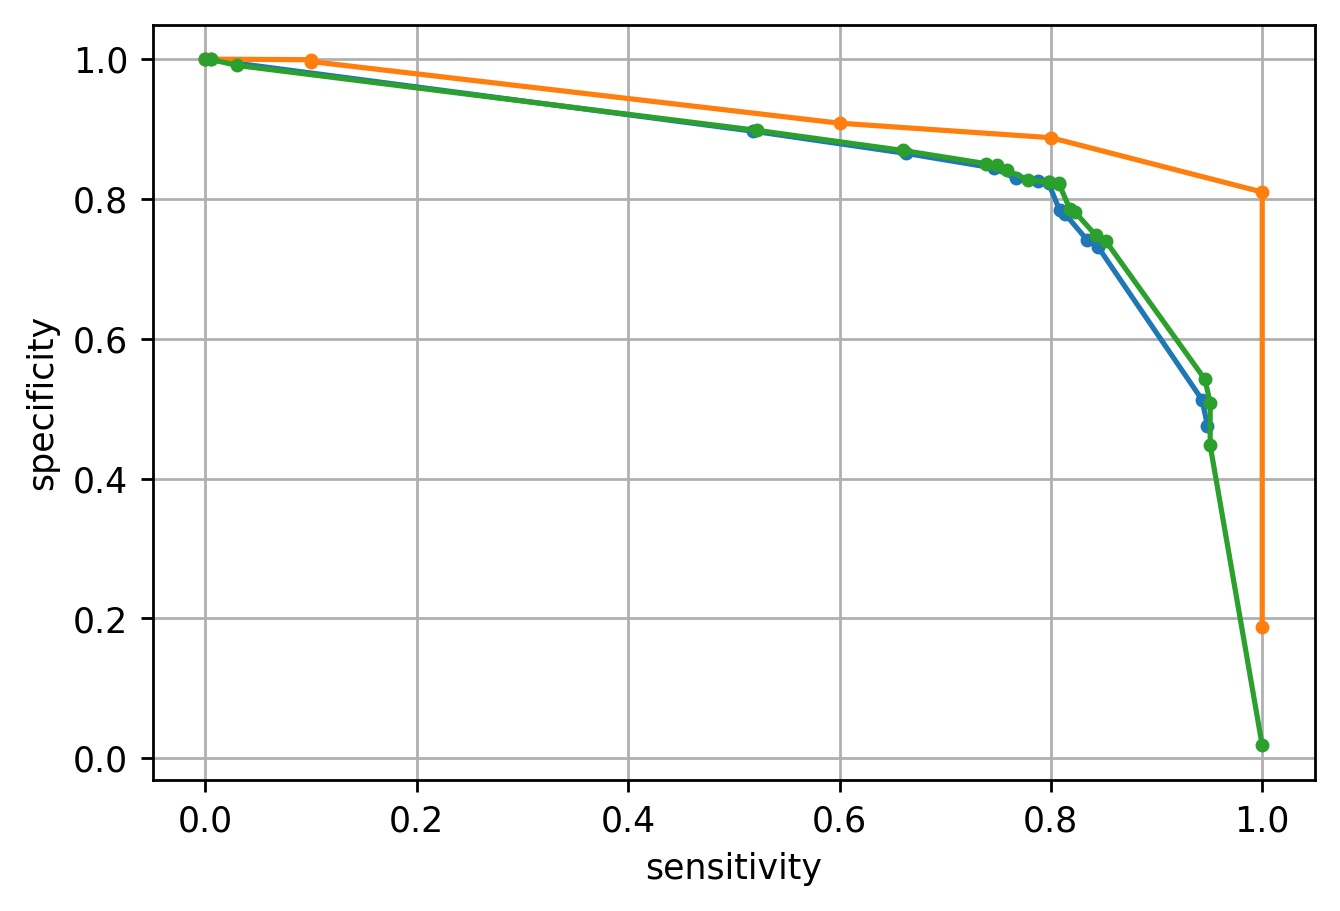

In [20]:
predict_and_save(all_model_old, X_old, y_old, 'pfigs_old', '')
predict_and_save(all_model_young, X_young, y_young, 'pfigs_young', '')
predict_and_save(all_model_all, X_df_clean, y, 'pfigs_all', '')

In [16]:
pkl.dump(all_model_old, open(oj(RESULT_PATH, 'all_model_old.pkl'), 'wb'))
pkl.dump(all_model_young, open(oj(RESULT_PATH, 'all_model_young.pkl'), 'wb'))

In [267]:
pkl.load(open('notebooks/transfertree/results/csi/seed_6/all_model_old.pkl', 'rb')).max_rules

8

In [107]:
dt = DecisionTreeClassifier(max_depth=1).fit(X_df_clean, y)

In [109]:
dt.tree_.value

array([[[11841.,   203.]],

       [[11613.,   154.]],

       [[  228.,    49.]]])

In [111]:
imodels.FIGSClassifier(max_rules=3).fit(X_df_clean, y)

[[[0.01685487]]

 [[0.01308745]]

 [[0.17689531]]]
[[[ 1.76206078e-17]]

 [[-4.08219084e-03]]

 [[ 1.13258875e-01]]]
[[[0.01308745]]

 [[0.00939833]]

 [[0.12303665]]]
[[[0.17689531]]

 [[0.31730769]]

 [[0.09248555]]]
[[[0.16530378]]

 [[0.30672225]]

 [[0.08028921]]]
[[[0.01336032]]

 [[0.07747669]]

 [[0.01024649]]]
[[[-5.36866669e-16]]

 [[ 6.75033882e-02]]

 [[-3.64484034e-03]]]
[[[-0.00408219]]

 [[ 0.0634212 ]]

 [[-0.00786577]]]
[[[0.11325887]]

 [[0.2271996 ]]

 [[0.03849934]]]
[[[0.01342994]]

 [[0.07747669]]

 [[0.01031949]]]
[[[-5.43964574e-16]]

 [[ 6.75033882e-02]]

 [[-3.64484034e-03]]]
[[[-0.00408219]]

 [[ 0.0634212 ]]

 [[-0.00786577]]]
[[[0.16234637]]

 [[0.30699506]]

 [[0.07538993]]]
[[[0.2271996 ]]

 [[0.17067429]]

 [[0.51820028]]]
[[[0.03849934]]

 [[0.03538583]]

 [[0.82310469]]]


FIGSClassifier(max_rules=3)